<a href="https://colab.research.google.com/github/AdrianaGRO/duty-free-sales/blob/main/DutyFreeSalesAnalyzer_Day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Py.3 - Duty-Free Sales Analyzer.ipynb**

In [1]:
!pip install openai


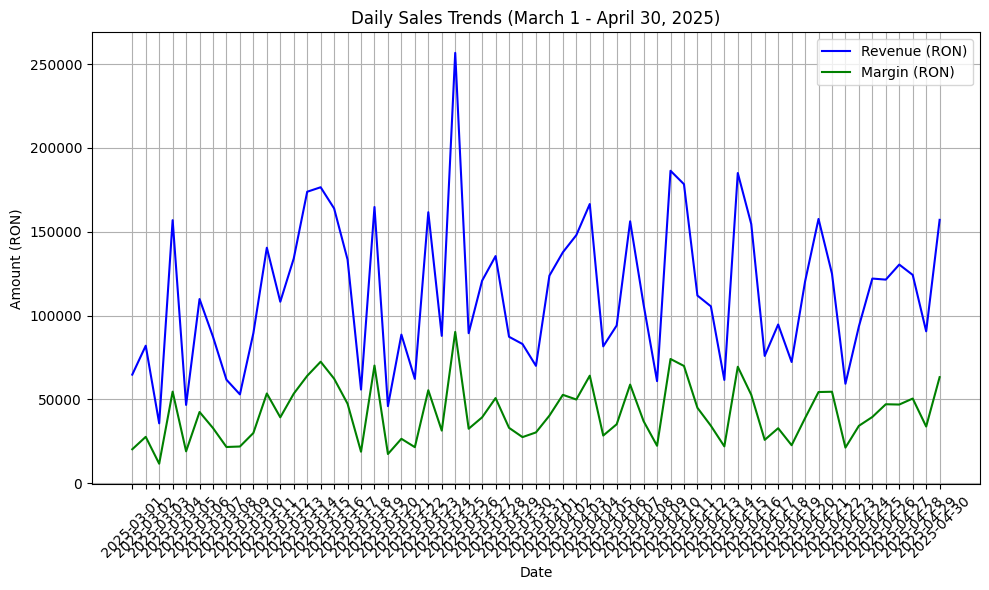

Travel Retail Romania - Duty Free Sales (Day 5: Predictions + RAG)
-----------------------------------------------------------------------
First 5 rows of data:
         Date           Product    Category  Price (RON)  \
0  2025-03-01  Ray-Ban Wayfarer  Sunglasses       358.74   
1  2025-03-01        Pepsi 0.5l   Beverages        11.72   
2  2025-03-01      Baileys 0.7l     Spirits       181.99   
3  2025-03-01        Pepsi 0.5l   Beverages        13.81   
4  2025-03-01      Dom Perignon     Spirits       113.61   

   Acquisition Price (RON)  Units Sold  Revenue (RON)  Margin (RON)  
0                   231.00          44       15784.56       5620.56  
1                     7.50           3          35.16         12.66  
2                   126.91          47        8553.53       2588.76  
3                     8.26          17         234.77         94.35  
4                    80.64          15        1704.15        494.55  

External Trends:
         Date                           

In [12]:
# Step 1: Import pandas
import pandas as pd
import openai
from google.colab import userdata
import matplotlib.pyplot as plt
import os



#Step 2 : Set up the OpenAI API Key

openai.api_key = userdata.get('OPEN_AI')
if not openai.api_key:
  raise ValueError("OPENAI API key not found in Colabs Secrets as 'OPEN_AI'.")

#Step 3: Load the Excel
df = pd.read_excel("duty_free_sales_day3.xlsx")
promo_df =pd.read_csv("promo.csv")

##Step 4 Mock external data (RAG)
external_data = pd.DataFrame({
    "Date": ["2025-05-01", "2025-05-15","2025-06-01", "2025-06-10", "2025-06-20" ],
    "Trend": [
        "20% increase predicted",
        "Summer duty-free promos trending",
        "Children day, 1 June, Chocolate and Toys Boost ",
        "Season festival boosts spirts",
        "Luxury sunglasses demand up"
        ]
})

##Step 5: Calculate trends and predict

daily_trends = df.groupby("Date")[["Revenue (RON)", "Margin (RON)"]].sum()
avg_revenue =daily_trends["Revenue (RON)"].sum() / 61 #March and April = 61 days


#Step 6: Plot trend analysis
plt.figure(figsize=(10, 6))
plt.plot(daily_trends.index, daily_trends["Revenue (RON)"], label="Revenue (RON)", color= "blue")
plt.plot(daily_trends.index, daily_trends["Margin (RON)"], label="Margin (RON)", color= "green")
plt.title("Daily Sales Trends (March 1 - April 30, 2025)")
plt.xlabel("Date")
plt.ylabel("Amount (RON)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("trends_plot_day5.png")
plt.show()


#Step 7: Modular agent:
def validate_data(dataframe):
  if len(dataframe) != 1000 or dataframe["Units Sold"].sum() !=31264:
    raise ValueError("Data mismatch: Expected 1000 rows, 31264 units")
  return True



def predict(dataframe, trends, promo_data, external_data):
  avg_revenue = dataframe["Revenue (RON)"].sum() / 61 #Full period
  may_boost = 1.2 #20% boost from travel
  june_boost = 1.15 # June 15% from festivals
  june_1_boost = june_boost + 0.1
  if "Chocolate and Toys Boost" in external_data["Trend"].values:
    june_1_boost +=0.05 #Extra 5% for June 1
  return {
      "May": avg_revenue * 31 * may_boost,
      "June": avg_revenue * 30 * june_boost,
      "June 1": avg_revenue * 1 * june_1_boost #EXtra spike
  }



def summarize(dataframe, trends, promo_data, external_data):
  total_revenue = dataframe["Revenue (RON)"].sum()
  total_margin = dataframe["Margin (RON)"].sum()
  total_units = dataframe["Units Sold"].sum()
  top_products = dataframe.groupby("Product")["Revenue (RON)"].sum().nlargest(3)


  # Create a prompt for OpenAI
  prompt = (
      f"Travel Retail Romania - Duty-free sales report (March 1 - April 30, 2025):\n:"
      f"Total Revenue: {total_revenue:.2f} RON\n"
      f"Total Margin: {total_margin:.2f} RON\n"
      f"Total units sold: {total_units}\n"
      f"Top 3 Products:\n{top_products}\n"
      f"Trends:\n{trends.head(10)}...\n"
      f"Promo data:\n{promo_data}\n"
      f"External Trends:\n{external_data}\n"

      f"Predict May and june 2025 sales and suggest 3 promos for each. June 1, 2025 sales (highlight Children’s Day). Focus on insights avoid repeting numbers"
  )

  response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful sales analyst."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=500,
        temperature=0.7
    )
  #Extract the summary
  summary = response.choices[0].message.content.strip()

  #save to a text file
  with open("sales_summary_day5.txt", "w") as f:
    f.write(summary)
  return summary


# Step 8: Run
validate_data(df)
predictions = predict(df, daily_trends, promo_df, external_data)
print("Travel Retail Romania - Duty Free Sales (Day 5: Predictions + RAG)")
print("-----------------------------------------------------------------------")
print("First 5 rows of data:")
print(df.head())
print("\nExternal Trends:")
print(external_data)
print("\nRevenue Estimates:")
print(f"May 2025: {predictions['May']:.2f} RON")
print(f"June 2025: {predictions['June']:.2f} RON")
print(f"June 1, 2025: {predictions['June 1']:.2f} RON")
print("-----------------------------------------------------------------------")
print("\nAI Summary:")
print(summarize(df, daily_trends, promo_df, external_data))
print("-----------------------------------------------------------------------")